# Equipe:
Cleverton Carneiro, Gustavo Cordeiro e Igor Pardal Latini

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
sns.set(font_scale=1.2)

import warnings
warnings.filterwarnings('ignore')

import math

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

get_ipython().magic(u'matplotlib inline') #para imprimir no próprio notebook

# Visualização

In [2]:
#Funções auxiliares
def plot_correlation_map( df, figsize = (12,10)):
    corr = df.corr().round(2)
    _ , ax = plt.subplots(figsize = figsize)
    cmap = sns.diverging_palette(220,10, as_cmap=True)
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={'shrink':.9}, 
        ax=ax, 
        annot=True, 
        annot_kws={'fontsize':12}
    )
    
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df,row = row, col=col)
    facet.map(sns.barplot, cat, target)
    facet.add_legend()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

In [3]:
#Adaptado de https://www.kaggle.com/sachinkulkarni/titanic/an-interactive-data-science-tutorial
#Carrega a base de dados
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
full = train.append(test , ignore_index = True)
print("Datasets:\nCompleto: " , full.shape, "\nTreinamento:", train.shape,"\nTeste:",test.shape)

Datasets:
Completo:  (1309, 12) 
Treinamento: (891, 12) 
Teste: (418, 11)


In [4]:
#Identifica as características presentes
train.columns.values

#Descrição das variáveis
#We've got a sense of our variables, their class type, and the first few observations of each. We know we're working with 1309 observations of 12 variables. To make things a bit more explicit since a couple of the variable names aren't 100% illuminating, here's what we've got to deal with:
#Variable Description
#Survived: Survived (1) or died (0)
#Pclass: Passenger's class
#Name: Passenger's name
#Sex: Passenger's sex
#Age: Passenger's age
#SibSp: Number of siblings/spouses aboard
#Parch: Number of parents/children aboard
#Ticket: Ticket number
#Fare: Fare
#Cabin: Cabin
#Embarked: Port of embarkation

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [5]:
#Análise dos dados. Observe que é possível identificar dados inconsistentes. Por exemplo, idade mínima de 0.42! -- Será?
#Ver "Sobre as idades"
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


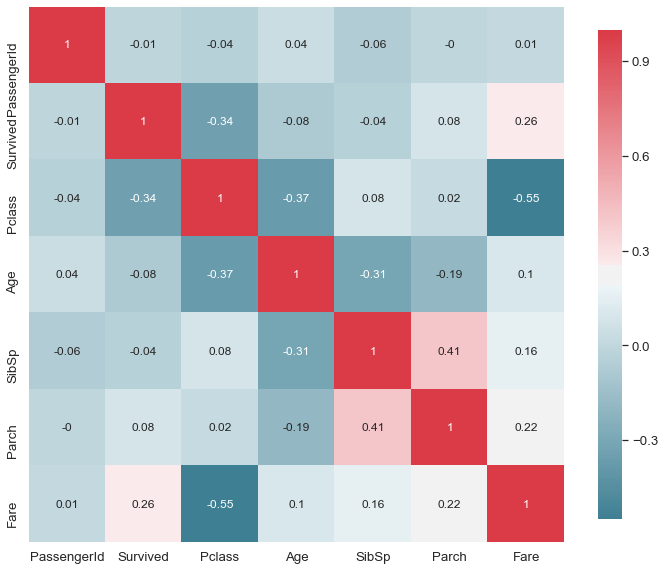

In [6]:
#Correlação entre as características.
#Pode dar uma ideia do que está relacionado com o que.
plot_correlation_map(train)

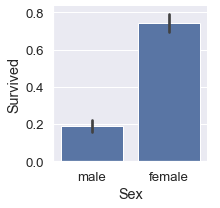

In [7]:
#Distribuição das amostras dentro de uma mesma classe
#Visualize a "Survival Rate" em relação aos seguintes atributos: Embarked, Sex, Pclass, SibSp, Parch
plot_categories(train, cat = 'Sex', target = 'Survived')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6df7fb86a0>,
      dtype=object)

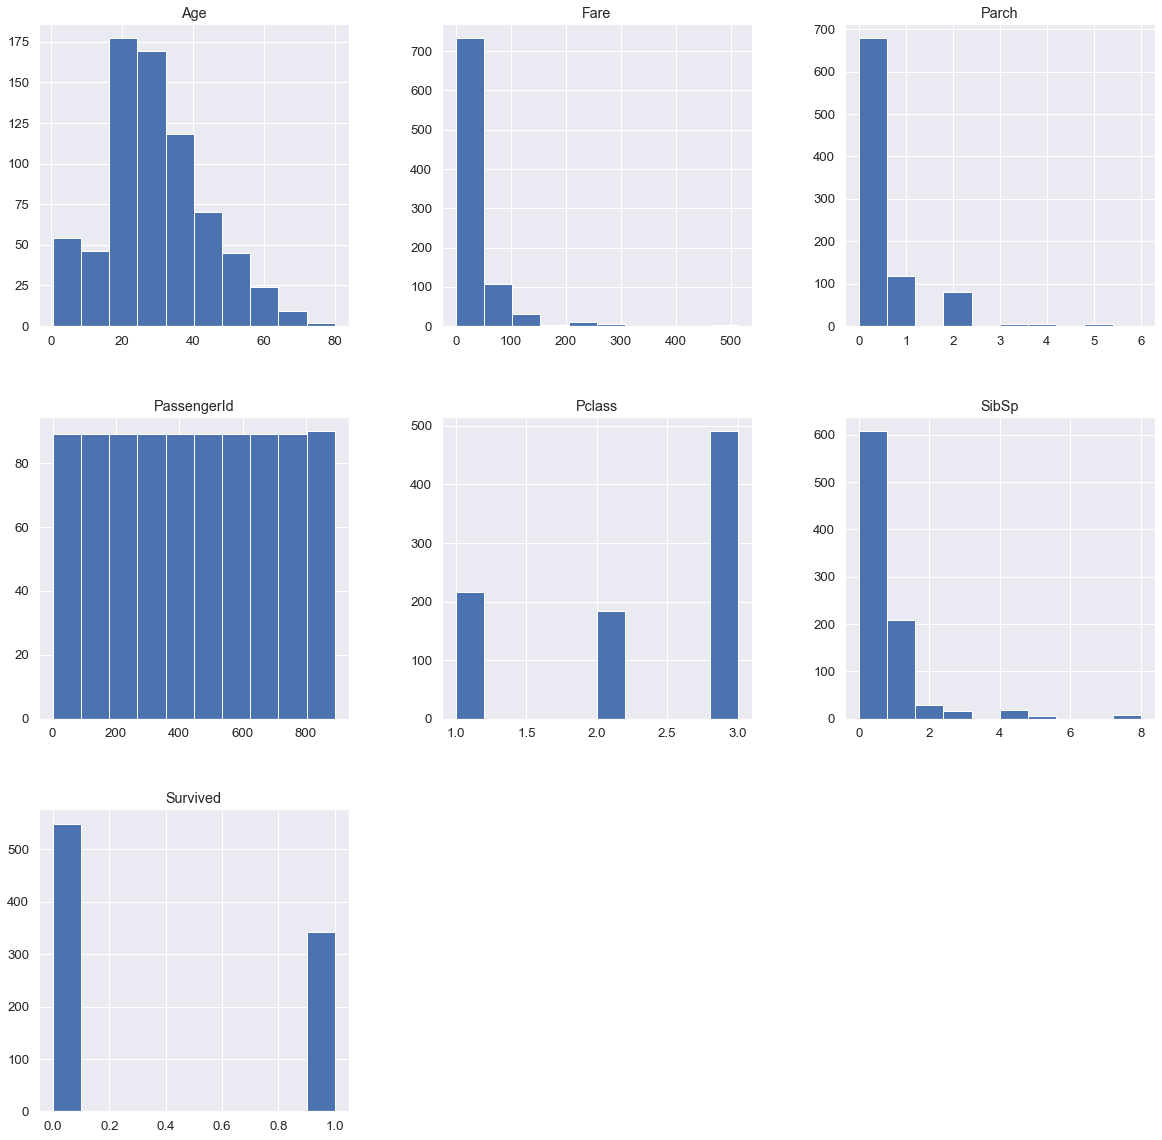

In [8]:
train.hist(figsize=(20,20))

# Ajustando os dados

### Novas colunas

In [9]:
#Altera o atributo "Sex" de valores nominais (Male/Female) para 0 e 1
full["Male"] = (full.Sex == "male").astype(int)
full = full.drop(['Sex'],axis=1)
full.head(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,SibSp,Survived,Ticket,Male
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,0.0,A/5 21171,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1.0,PC 17599,0


In [10]:
#Cria uma nova variável para cada valor único de "Embarked" (no caso, Embarked_C  Embarked_Q  Embarked_S)
embarked = pd.get_dummies(full.Embarked, prefix='Embarked')

#Cria uma nova variável para cada valor único de "Pclass"
pclass = pd.get_dummies(full.Pclass , prefix='Pclass' )

print(embarked.sum())
print(pclass.sum())

#junta novas colunas e remove antigas
full = pd.concat([full,embarked,pclass],axis=1)
full = full.drop(['Embarked','Pclass'],axis=1)
full.head(2)

Embarked_C    270
Embarked_Q    123
Embarked_S    914
dtype: int64
Pclass_1    323
Pclass_2    277
Pclass_3    709
dtype: int64


,Age,Cabin,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",0,1,1,0.0,A/5 21171,1,0,0,1,0,0,1
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1.0,PC 17599,0,1,0,0,1,0,0


In [11]:
#As distinções refletiam o status social e podem ser utilziados para prever a probabilidade de sobrevivência

title = pd.DataFrame()

#Extrai o título de cada nome
title['Title'] = full['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())

#Lista agregada de títulos
Title_Dictionary = {
                    "Capt":       "Officer",#Officer
                    "Col":        "Officer",#Officer
                    "Major":      "Officer",#Officer
                    "Jonkheer":   "Royalty",#Royalty
                    "Don":        "Royalty",#Royalty
                    "Sir" :       "Royalty",#Royalty
                    "Dr":         "Officer",#Officer
                    "Rev":        "Officer",#Officer
                    "the Countess":"Royalty",#Royalty
                    "Dona":       "Royalty",#Royalty
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"#Royalty
                    }

#Faz o mapeamento de cada título
title['Title'] = title.Title.map(Title_Dictionary)
#Cria uma nova variável para cada título
title = pd.get_dummies(title.Title)

print(title.sum())

#junta novas colunas 
full = pd.concat([full,title],axis=1)
full = full.drop(['Name'],axis=1)
full.head(2)

Master      61
Miss       262
Mr         757
Mrs        200
Officer     23
Royalty      6
dtype: int64


,Age,Cabin,Fare,Parch,PassengerId,SibSp,Survived,Ticket,Male,Embarked_C,...,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Master,Miss,Mr,Mrs,Officer,Royalty
0,22.0,NaN,7.2500,0,1,1,0.0,A/5 21171,1,0,...,1,0,0,1,0,0,1,0,0,0
1,38.0,C85,71.2833,0,2,1,1.0,PC 17599,0,1,...,0,1,0,0,0,0,0,1,0,0


In [12]:
#Extrai a categoria da cabine a partir do número
cabin = pd.DataFrame()

#Substitui dados faltantes por "U" (Uknown)
cabin['Cabin'] = full.Cabin.fillna( 'U' )

#Mapeia cada valor de cabine com a letra
cabin['Cabin'] = cabin['Cabin'].map(lambda c : c[0])

#Cria uma variável para cada categoria
cabin = pd.get_dummies(cabin['Cabin'] , prefix = 'Cabin')

print(cabin.sum())
#junta pois tem poucos dados 
cabin['Cabin_AB'] = cabin['Cabin_A']+cabin['Cabin_B']
cabin['Cabin_DE'] = cabin['Cabin_D']+cabin['Cabin_E']
cabin['Cabin_FG'] = cabin['Cabin_F']+cabin['Cabin_G']
cabin = cabin.drop(["Cabin_A","Cabin_B","Cabin_D","Cabin_E","Cabin_F","Cabin_G","Cabin_T"],axis=1)

print(cabin.sum())

#junta novas colunas e remove antigas
full = pd.concat([full,cabin],axis=1)
full = full.drop(['Cabin'],axis=1)

full.head(2)

Cabin_A      22
Cabin_B      65
Cabin_C      94
Cabin_D      46
Cabin_E      41
Cabin_F      21
Cabin_G       5
Cabin_T       1
Cabin_U    1014
dtype: int64
Cabin_C       94
Cabin_U     1014
Cabin_AB      87
Cabin_DE      87
Cabin_FG      26
dtype: int64


,Age,Fare,Parch,PassengerId,SibSp,Survived,Ticket,Male,Embarked_C,Embarked_Q,...,Miss,Mr,Mrs,Officer,Royalty,Cabin_C,Cabin_U,Cabin_AB,Cabin_DE,Cabin_FG
0,22.0,7.2500,0,1,1,0.0,A/5 21171,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1,38.0,71.2833,0,2,1,1.0,PC 17599,0,1,0,...,0,0,1,0,0,1,0,0,0,0


A nomenclatura das cabines está relacionada com a sua posição no navio, assim, unimos as cabines mais próximas. 
<img src="cabines.png" width=350>

In [13]:
#Ticket: Removido por possuir poucas amostras por cada classe
'''
#Caso não tenha prefixo, retorna XXX
def cleanTicket( ticket ):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

#Cria uma nova variável para cada caso
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )
print(ticket.sum())
'''
#junta novas colunas e remove antigas
#full = pd.concat([full,ticket],axis=1)

full = full.drop(['Ticket'],axis=1)
#full.head(2)
#ticket.shape

Decidimos não adicionar os tickets pois adiciona muitas colunas com pouco valor.

In [14]:
#familySize: Removido pela informação ser repetida
'''
#Cria variáveis para representar o tamanho da família e também cada categoria
family = pd.DataFrame()

#Cria nova característica que representa o tamanho da família (quantidade de membros)
family['FamilySize'] = full['Parch'] + full['SibSp'] + 1

#Cria nova características para representar o tipo de família 
family['Family_Single'] = family['FamilySize'].map(lambda s : 1 if s == 1 else 0)
#family['Family_Small']  = family['FamilySize'].map(lambda s : 1 if 2 <= s <= 4 else 0)
#family['Family_Large']  = family['FamilySize'].map(lambda s : 1 if 5 <= s else 0)
family['Family_Small']  = family['FamilySize'].map(lambda s : 1 if 2 <= s <= 3 else 0)
family['Family_Large']  = family['FamilySize'].map(lambda s : 1 if 4 <= s else 0)
print(family.sum())

#junta novas colunas e remove antigas
full = pd.concat([full,family],axis=1)
full = full.drop(['FamilySize'],axis=1)

full.head(2)
'''
None

Decidimos não adicionar _FamilySize_ pois essa informação já esta em _Parch_ e _SibSp_.

In [15]:
#ID dos passageiros não tem significado
full = full.drop(["PassengerId"],axis=1)
full.shape

(1309, 23)

### Sobre as idades:
De acordo com essa entrada da Wikipedia: https://pt.wikipedia.org/wiki/Millvina_Dean, a passageira mais nova a embarcar no Titanic tinha apenas 2 meses de idade. Isso equivale a 0,17 anos. Dessa forma, como saber se as outras idades, menores que 1, estão erradas? Olhando todos os dados, 0,17 é, de fato, a menor idade.

In [16]:
full[full.Age < 1]

,Age,Fare,Parch,SibSp,Survived,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,...,Miss,Mr,Mrs,Officer,Royalty,Cabin_C,Cabin_U,Cabin_AB,Cabin_DE,Cabin_FG
78,0.83,29.0000,2,0,1.0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
305,0.92,151.5500,2,1,1.0,1,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
469,0.75,19.2583,1,2,1.0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
644,0.75,19.2583,1,2,1.0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
755,0.67,14.5000,1,1,1.0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
803,0.42,8.5167,1,0,1.0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
831,0.83,18.7500,1,1,1.0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1092,0.33,14.4000,2,0,NaN,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1141,0.92,27.7500,2,1,NaN,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
1172,0.75,13.7750,1,1,NaN,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


### Missing Values

In [17]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 23 columns):
Age           1046 non-null float64
Fare          1308 non-null float64
Parch         1309 non-null int64
SibSp         1309 non-null int64
Survived      891 non-null float64
Male          1309 non-null int64
Embarked_C    1309 non-null uint8
Embarked_Q    1309 non-null uint8
Embarked_S    1309 non-null uint8
Pclass_1      1309 non-null uint8
Pclass_2      1309 non-null uint8
Pclass_3      1309 non-null uint8
Master        1309 non-null uint8
Miss          1309 non-null uint8
Mr            1309 non-null uint8
Mrs           1309 non-null uint8
Officer       1309 non-null uint8
Royalty       1309 non-null uint8
Cabin_C       1309 non-null uint8
Cabin_U       1309 non-null uint8
Cabin_AB      1309 non-null uint8
Cabin_DE      1309 non-null uint8
Cabin_FG      1309 non-null uint8
dtypes: float64(3), int64(3), uint8(17)
memory usage: 83.2 KB


In [18]:
#Muitos algoritmos requerem que todas as amostras possuam valores atribuídos para todas as características. 
#No caso de dados faltantes, uma possibilidade é preenchê-los com o valor médio das demais observações.

#Preenche os valores que faltam em "Age" com a média das demais idades
full['Age'] = full.Age.fillna(full.Age.mean())

#O mesmo para "Fare"
full['Fare'] = full.Fare.fillna(full.Fare.mean())

full.head(2)

,Age,Fare,Parch,SibSp,Survived,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,...,Miss,Mr,Mrs,Officer,Royalty,Cabin_C,Cabin_U,Cabin_AB,Cabin_DE,Cabin_FG
0,22.0,7.2500,0,1,0.0,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
1,38.0,71.2833,0,1,1.0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0


In [19]:
#Seleciona as características que serão incluídas no descritor (vetor de características)
#full_all = pd.concat([imputed, embarked, family, sex, title, full.Survived] , axis=1)
#full_all.head()

# Visualização 2

In [20]:
#Separa novamente dados de treino e test
survived = full['Survived'][:train.shape[0]]
train = full[:train.shape[0]]
test = full[train.shape[0]:]
test = test.drop(['Survived'],axis=1)

train.shape,test.shape

((891, 23), (418, 22))

In [21]:
#Análise dos dados.
train.describe()

,Age,Fare,Parch,SibSp,Survived,Male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,...,Miss,Mr,Mrs,Officer,Royalty,Cabin_C,Cabin_U,Cabin_AB,Cabin_DE,Cabin_FG
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.735277,32.204208,0.381594,0.523008,0.383838,0.647587,0.188552,0.086420,0.722783,0.242424,...,0.206510,0.580247,0.142536,0.020202,0.005612,0.066218,0.771044,0.069585,0.072952,0.019080
std,13.002218,49.693429,0.806057,1.102743,0.486592,0.477990,0.391372,0.281141,0.447876,0.428790,...,0.405028,0.493796,0.349796,0.140770,0.074743,0.248802,0.420397,0.254589,0.260203,0.136882
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,29.881138,14.454200,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,35.000000,31.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,80.000000,512.329200,6.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


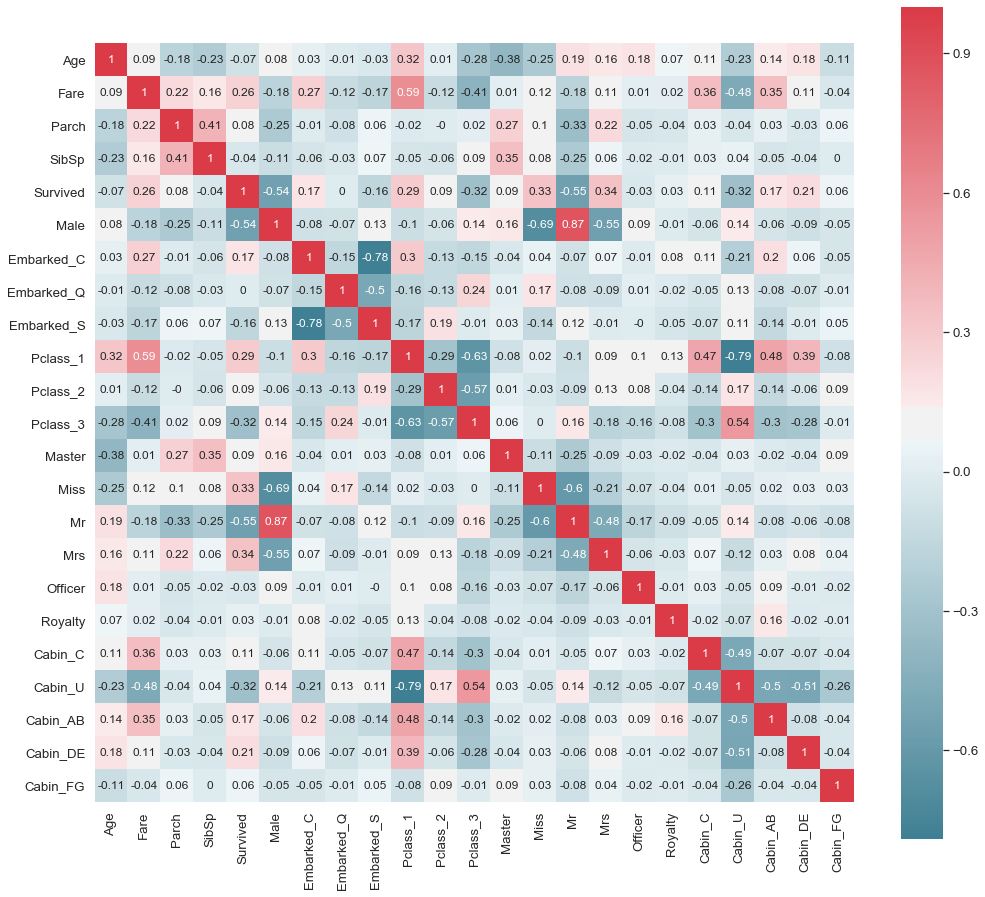

In [22]:
#Correlação entre as características.
#Pode dar uma ideia do que está relacionado com o que.
plot_correlation_map(train,figsize=(17,17))

In [23]:
%%time
#g = sns.pairplot(train,vars=train.columns[:-1], hue='Survived')#, palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
#g.savefig("output.png")

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.7 µs


### Split Dados

Vamos utilizar 4 bases de dados diferentes para os testes:
 - __full__: todas as colunas
 - __less__: somente as colunas mais relevantes
 - __pca16__: PCA 16 da base full
 - __pca10__: PCA 10 da base full

Para os __PCAs__ o número 16 foi escolhido para poder comparar com a base less e o número 10 foi escolhido arbitrariamente. 

Para a base __less__ removemos:
 - Officer, Royalty e Cabin_FG por terem pouco amostras positivas.
 - Mr por ter alta correlação com Male.
 - Embarked_Q e P_Class_2 por terem pouca correlação com a sobrevivência e por serem o complementares das restantes.  

In [24]:
from sklearn.decomposition import PCA

#A partir apenas das amostras do arquivo train.csv, cria a base de treinamento e teste.
X = full[0:train.shape[0]]
y = survived
X = X.drop(['Survived'],axis=1)

#dados full
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, train_size = .7)
print("full shape",X_train_full.shape)

#dados less
X_less = X[['Age', 'Fare', 'Parch', 'SibSp', 'Male', 'Embarked_C',
            'Embarked_S', 'Pclass_1', 'Pclass_3', 'Master', 'Miss', 
            'Mrs', 'Cabin_C', 'Cabin_U', 'Cabin_AB','Cabin_DE']]
X_train_less, X_test_less, y_train_less, y_test_less = train_test_split(X_less, y, train_size = .7)
print("less shape",X_train_less.shape)

#dados pca
pca16 = PCA(n_components=16)
X_pca16 = pca16.fit_transform(X)
X_train_pca16, X_test_pca16, y_train_pca16, y_test_pca16 = train_test_split(X_pca16 , y, train_size = .7)
print("pca16 shape",X_train_pca16.shape)

pca10 = PCA(n_components=10)
X_pca10 = pca10.fit_transform(X)
X_train_pca10, X_test_pca10, y_train_pca10, y_test_pca10 = train_test_split(X_pca10 , y, train_size = .7)
print("pca10 shape",X_train_pca10.shape)

full shape (623, 22)
less shape (623, 16)
pca16 shape (623, 16)
pca10 shape (623, 10)


***
# Processo de Classificação

4 modelos foram testados com 4 bases de dados diferentes, em todos os casos utilizamos GridSearch. Assim, obtivemos 16 resultados diferentes. 

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
#DataFrame para a apresentação dos resultados de forma resumida
df_resumo = pd.DataFrame(columns=['Modelo',"Tabela","Accuracy","F-measure","best_params","Preditor"])

### Função de Avaliação

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(font_scale=1.2)

#Função utilizada para avaliar todos os modelos individualmente
def avalia_resultado(y, y_pred):
    
    fig, axs = plt.subplots(ncols=2,figsize=(12,4))
    
    #Confusion Matrix
    sns.set(font_scale=1.2)
    confusionMatrix = confusion_matrix(y, y_pred)
    
    df_cm = pd.DataFrame(confusionMatrix, index=["Died","Survived"],columns=["Died","Survived"])
    sns.heatmap(df_cm, annot=True, ax=axs[0])
    
    #Curva de Roc
    sns.set(font_scale=1)
    y_pred_2colunas = np.zeros((len(y_pred),2))
    y_pred_2colunas[range(len(y_pred)),y_pred.astype(int)] = 1
    skplt.metrics.plot_roc(y,y_pred_2colunas,plot_micro=False,plot_macro=False, ax=axs[1])

    #Avalia métricas
    report = classification_report(y, y_pred, target_names=["Died","Survived"],output_dict = True)
    df_report = pd.DataFrame(report)
    
    plt.show()
    return df_report

### KNN

In [28]:
from sklearn import neighbors

full:


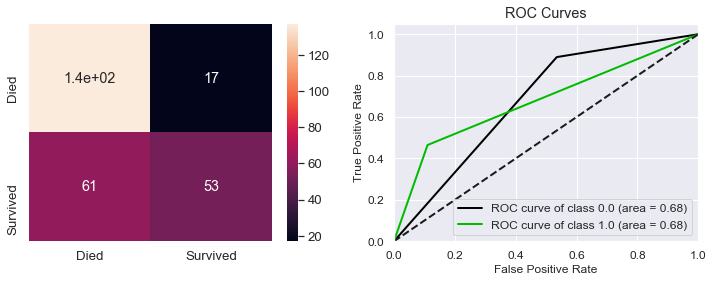

                 Died    Survived  accuracy   macro avg  weighted avg
f1-score     0.778409    0.576087  0.708955    0.677248      0.692347
precision    0.691919    0.757143  0.708955    0.724531      0.719664
recall       0.889610    0.464912  0.708955    0.677261      0.708955
support    154.000000  114.000000  0.708955  268.000000    268.000000
{'n_neighbors': 8}
----------------------------------------------------------------------------------------------------
less:


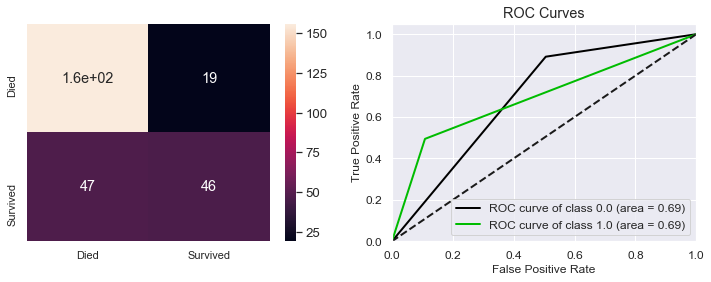

                 Died   Survived  accuracy   macro avg  weighted avg
f1-score     0.825397   0.582278  0.753731    0.703838      0.741031
precision    0.768473   0.707692  0.753731    0.738083      0.747381
recall       0.891429   0.494624  0.753731    0.693026      0.753731
support    175.000000  93.000000  0.753731  268.000000    268.000000
{'n_neighbors': 4}
----------------------------------------------------------------------------------------------------
pca16:


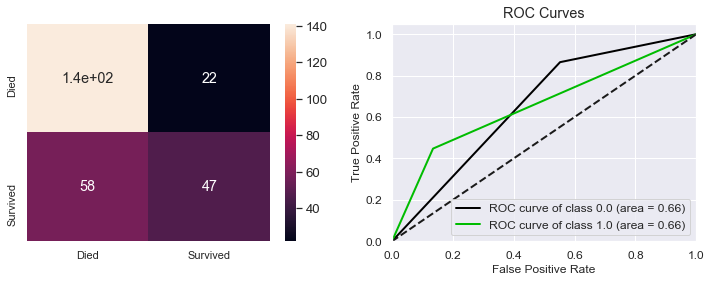

                 Died    Survived  accuracy   macro avg  weighted avg
f1-score     0.779006    0.540230  0.701493    0.659618      0.685455
precision    0.708543    0.681159  0.701493    0.694851      0.697814
recall       0.865031    0.447619  0.701493    0.656325      0.701493
support    163.000000  105.000000  0.701493  268.000000    268.000000
{'n_neighbors': 6}
----------------------------------------------------------------------------------------------------
pca10:


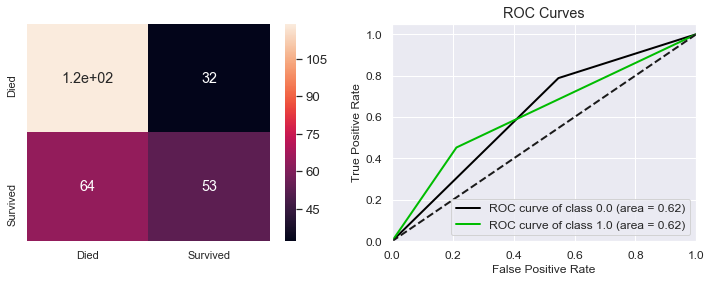

                 Died    Survived  accuracy   macro avg  weighted avg
f1-score     0.712575    0.524752  0.641791    0.618664      0.630578
precision    0.650273    0.623529  0.641791    0.636901      0.638598
recall       0.788079    0.452991  0.641791    0.620535      0.641791
support    151.000000  117.000000  0.641791  268.000000    268.000000
{'n_neighbors': 6}
CPU times: user 3.95 s, sys: 505 ms, total: 4.45 s
Wall time: 3.55 s


In [29]:
%%time

#Varia K de 2 em 2, a partir de 2, até 20
parameters = {'n_neighbors':np.arange(2,20,2)}

clf_nkk = neighbors.KNeighborsClassifier()

#Usa cross validation com cv = 5
clf_nkk = GridSearchCV(clf_nkk, parameters, cv=5)

#full
print("full:")
clf_nkk.fit(X_train_full, y_train_full)
preditor_full = clf_nkk.predict(X_test_full)
df_resultado = avalia_resultado(y_test_full, preditor_full)
df_resumo = df_resumo.append({"Modelo":"KNN",
                              "Tabela":"Full",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":clf_nkk.best_params_,
                              "Preditor":preditor_full},ignore_index=True,)
print(df_resultado)
print(clf_nkk.best_params_)
print('-'*100)

#less
print("less:")
clf_nkk.fit(X_train_less, y_train_less)
preditor_less = clf_nkk.predict(X_test_less)
df_resultado = avalia_resultado(y_test_less, preditor_less)
df_resumo = df_resumo.append({"Modelo":"KNN",
                              "Tabela":"Less",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":clf_nkk.best_params_,
                              "Preditor":preditor_less},ignore_index=True,)
print(df_resultado)
print(clf_nkk.best_params_)
print('-'*100)

#pca16
print("pca16:")
clf_nkk.fit(X_train_pca16, y_train_pca16)
preditor_pca16 = clf_nkk.predict(X_test_pca16)
df_resultado = avalia_resultado(y_test_pca16, preditor_pca16)
df_resumo = df_resumo.append({"Modelo":"KNN",
                              "Tabela":"pca16",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":clf_nkk.best_params_,
                              "Preditor":preditor_pca16},ignore_index=True,)
print(df_resultado)
print(clf_nkk.best_params_)
print('-'*100)

#pca10
print("pca10:")
clf_nkk.fit(X_train_pca10, y_train_pca10)
preditor_pca10 = clf_nkk.predict(X_test_pca10)
df_resultado = avalia_resultado(y_test_pca10, preditor_pca10)
df_resumo = df_resumo.append({"Modelo":"KNN",
                              "Tabela":"pca10",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":clf_nkk.best_params_,
                              "Preditor":preditor_pca10},ignore_index=True,)
print(df_resultado)
print(clf_nkk.best_params_)

### Decision Tree

full:


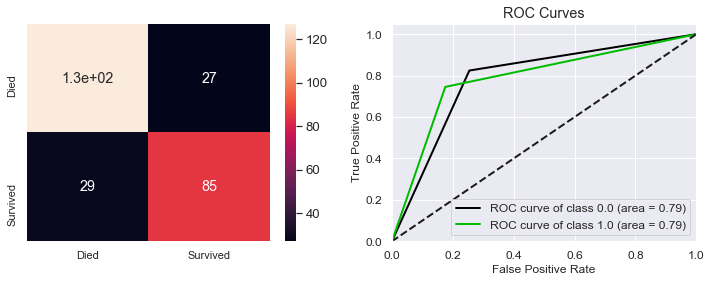

                 Died    Survived  accuracy   macro avg  weighted avg
f1-score     0.819355    0.752212  0.791045    0.785784      0.790794
precision    0.814103    0.758929  0.791045    0.786516      0.790633
recall       0.824675    0.745614  0.791045    0.785145      0.791045
support    154.000000  114.000000  0.791045  268.000000    268.000000
{'criterion': 'entropy', 'max_depth': 3, 'splitter': 'best'}
----------------------------------------------------------------------------------------------------
less:


/home/cordeiro/env/py3im/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


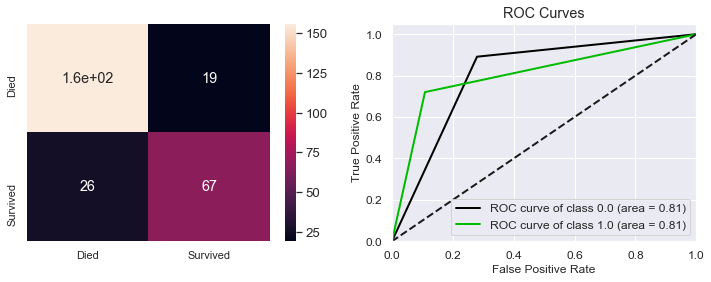

                 Died   Survived  accuracy   macro avg  weighted avg
f1-score     0.873950   0.748603   0.83209    0.811276      0.830453
precision    0.857143   0.779070   0.83209    0.818106      0.830050
recall       0.891429   0.720430   0.83209    0.805929      0.832090
support    175.000000  93.000000   0.83209  268.000000    268.000000
{'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'}
----------------------------------------------------------------------------------------------------
pca16:


/home/cordeiro/env/py3im/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


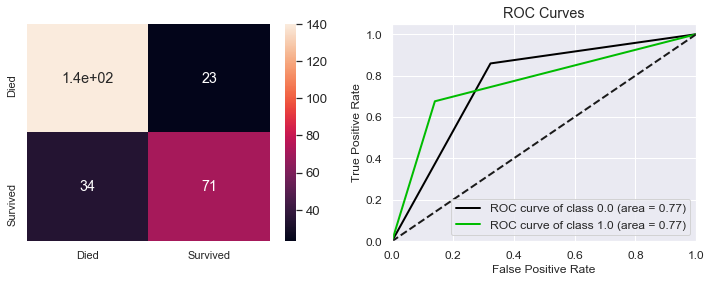

                 Died    Survived  accuracy   macro avg  weighted avg
f1-score     0.830861    0.713568  0.787313    0.772214      0.784906
precision    0.804598    0.755319  0.787313    0.779958      0.785291
recall       0.858896    0.676190  0.787313    0.767543      0.787313
support    163.000000  105.000000  0.787313  268.000000    268.000000
{'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}
----------------------------------------------------------------------------------------------------
pca10:


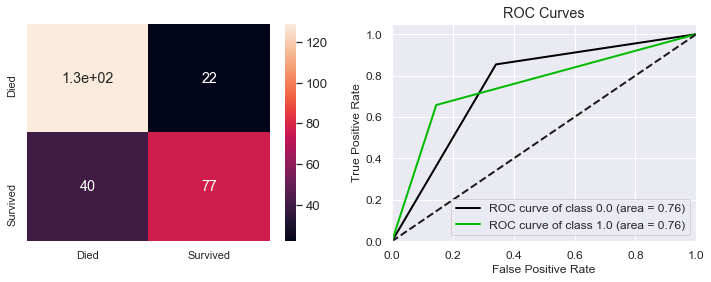

                 Died    Survived  accuracy   macro avg  weighted avg
f1-score     0.806250    0.712963  0.768657    0.759606      0.765524
precision    0.763314    0.777778  0.768657    0.770546      0.769628
recall       0.854305    0.658120  0.768657    0.756212      0.768657
support    151.000000  117.000000  0.768657  268.000000    268.000000
{'criterion': 'entropy', 'max_depth': 7, 'splitter': 'random'}
CPU times: user 8.11 s, sys: 478 ms, total: 8.59 s
Wall time: 7.69 s


In [30]:
%%time

parameters = {"max_depth":np.arange(3,30,2),"criterion":["gini", "entropy"],"splitter":["best", "random"]}
    
tree_clf = tree.DecisionTreeClassifier()

#Usa cross validation com cv = 5
tree_clf = GridSearchCV(tree_clf, parameters, cv=5)

#full
print("full:")
tree_clf.fit(X_train_full, y_train_full)
preditor_full = tree_clf.predict(X_test_full)
df_resultado = avalia_resultado(y_test_full, preditor_full)
df_resumo = df_resumo.append({"Modelo":"Decision Tree",
                              "Tabela":"Full",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":tree_clf.best_params_,
                              "Preditor":preditor_full},ignore_index=True,)
print(df_resultado)
print(tree_clf.best_params_)
print('-'*100)

#less
print("less:")
tree_clf.fit(X_train_less, y_train_less)
preditor_less = tree_clf.predict(X_test_less)
df_resultado = avalia_resultado(y_test_less, preditor_less)
df_resumo = df_resumo.append({"Modelo":"Decision Tree",
                              "Tabela":"Less",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":tree_clf.best_params_,
                              "Preditor":preditor_less},ignore_index=True,)
print(df_resultado)
print(tree_clf.best_params_)
print('-'*100)

#pca16
print("pca16:")
tree_clf.fit(X_train_pca16, y_train_pca16)
preditor_pca16 = tree_clf.predict(X_test_pca16)
df_resultado = avalia_resultado(y_test_pca16, preditor_pca16)
df_resumo = df_resumo.append({"Modelo":"Decision Tree",
                              "Tabela":"pca16",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":tree_clf.best_params_,
                              "Preditor":preditor_pca16},ignore_index=True,)
print(df_resultado)
print(tree_clf.best_params_)
print('-'*100)

#pca10
print("pca10:")
tree_clf.fit(X_train_pca10, y_train_pca10)
preditor_pca10 = tree_clf.predict(X_test_pca10)
df_resultado = avalia_resultado(y_test_pca10, preditor_pca10)
df_resumo = df_resumo.append({"Modelo":"Decision Tree",
                              "Tabela":"pca10",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":tree_clf.best_params_,
                              "Preditor":preditor_pca10},ignore_index=True,)
print(df_resultado)
print(tree_clf.best_params_)

### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

full:


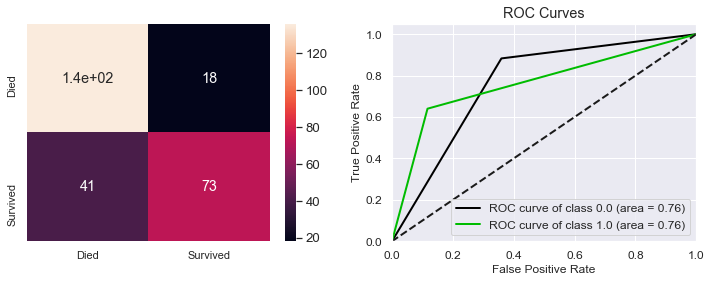

                 Died    Survived  accuracy   macro avg  weighted avg
f1-score     0.821752    0.712195  0.779851    0.766974      0.775150
precision    0.768362    0.802198  0.779851    0.785280      0.782755
recall       0.883117    0.640351  0.779851    0.761734      0.779851
support    154.000000  114.000000  0.779851  268.000000    268.000000
{'criterion': 'entropy', 'n_estimators': 10}
----------------------------------------------------------------------------------------------------
less:


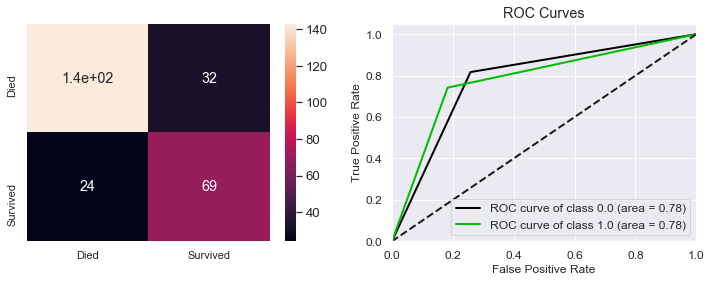

                 Died   Survived  accuracy   macro avg  weighted avg
f1-score     0.836257   0.711340  0.791045    0.773799      0.792909
precision    0.856287   0.683168  0.791045    0.769728      0.796213
recall       0.817143   0.741935  0.791045    0.779539      0.791045
support    175.000000  93.000000  0.791045  268.000000    268.000000
{'criterion': 'gini', 'n_estimators': 65}
----------------------------------------------------------------------------------------------------
pca16:


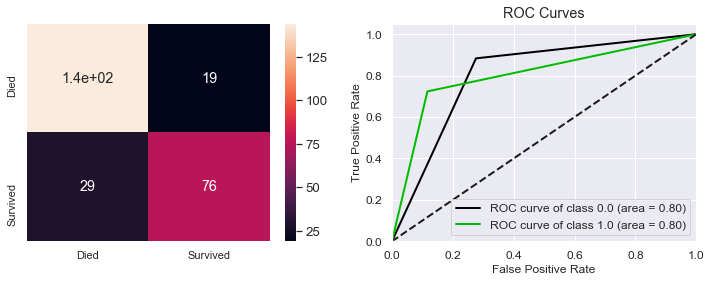

                 Died   Survived  accuracy   macro avg  weighted avg
f1-score     0.857143    0.76000  0.820896    0.808571      0.819083
precision    0.832370    0.80000  0.820896    0.816185      0.819688
recall       0.883436    0.72381  0.820896    0.803623      0.820896
support    163.000000  105.00000  0.820896  268.000000    268.000000
{'criterion': 'gini', 'n_estimators': 35}
----------------------------------------------------------------------------------------------------
pca10:


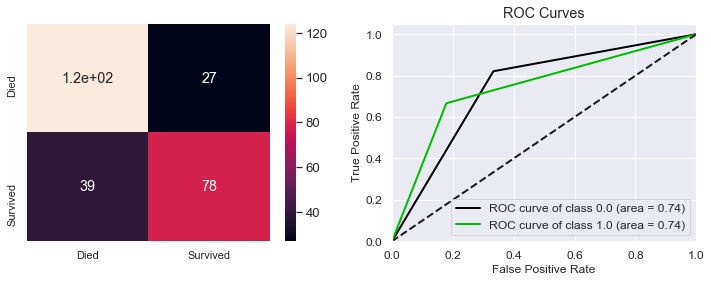

                 Died    Survived  accuracy   macro avg  weighted avg
f1-score     0.789809    0.702703  0.753731    0.746256      0.751781
precision    0.760736    0.742857  0.753731    0.751797      0.752931
recall       0.821192    0.666667  0.753731    0.743929      0.753731
support    151.000000  117.000000  0.753731  268.000000    268.000000
{'criterion': 'gini', 'n_estimators': 95}
CPU times: user 1min 1s, sys: 514 ms, total: 1min 1s
Wall time: 1min 1s


In [32]:
%%time

parameters = {"n_estimators":np.arange(10,100, 5),"criterion":["gini", "entropy"]}

rf_clf = RandomForestClassifier()

#Usa cross validation com cv = 5
rf_clf = GridSearchCV(rf_clf, parameters, cv=5)

#full
print("full:")
rf_clf.fit(X_train_full, y_train_full)
preditor_full = rf_clf.predict(X_test_full)
df_resultado = avalia_resultado(y_test_full, preditor_full)
df_resumo = df_resumo.append({"Modelo":"Random Forest",
                              "Tabela":"Full",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":rf_clf.best_params_,
                              "Preditor":preditor_full},ignore_index=True,)
print(df_resultado)
print(rf_clf.best_params_)
print('-'*100)

#less
print("less:")
rf_clf.fit(X_train_less, y_train_less)
preditor_less = rf_clf.predict(X_test_less)
df_resultado = avalia_resultado(y_test_less, preditor_less)
df_resumo = df_resumo.append({"Modelo":"Random Forest",
                              "Tabela":"Less",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":rf_clf.best_params_,
                              "Preditor":preditor_less},ignore_index=True,)
print(df_resultado)
print(rf_clf.best_params_)
print('-'*100)

#pca16
print("pca16:")
rf_clf.fit(X_train_pca16, y_train_pca16)
preditor_pca16 = rf_clf.predict(X_test_pca16)
df_resultado = avalia_resultado(y_test_pca16, preditor_pca16)
df_resumo = df_resumo.append({"Modelo":"Random Forest",
                              "Tabela":"pca16",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":rf_clf.best_params_,
                              "Preditor":preditor_pca16},ignore_index=True,)
print(df_resultado)
print(rf_clf.best_params_)
print('-'*100)

#pca10
print("pca10:")
rf_clf.fit(X_train_pca10, y_train_pca10)
preditor_pca10 = rf_clf.predict(X_test_pca10)
df_resultado = avalia_resultado(y_test_pca10, preditor_pca10)
df_resumo = df_resumo.append({"Modelo":"Random Forest",
                              "Tabela":"pca10",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":rf_clf.best_params_,
                              "Preditor":preditor_pca10},ignore_index=True,)
print(df_resultado)
print(rf_clf.best_params_)

### Gaussian Naive Bayes

In [33]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB

full:


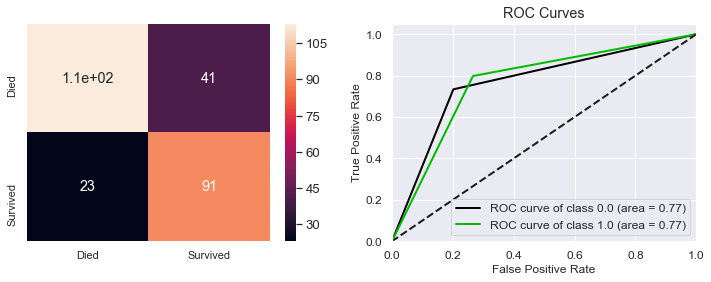

                 Died    Survived  accuracy   macro avg  weighted avg
f1-score     0.779310    0.739837  0.761194    0.759574      0.762520
precision    0.830882    0.689394  0.761194    0.760138      0.770697
recall       0.733766    0.798246  0.761194    0.766006      0.761194
support    154.000000  114.000000  0.761194  268.000000    268.000000
----------------------------------------------------------------------------------------------------
less:


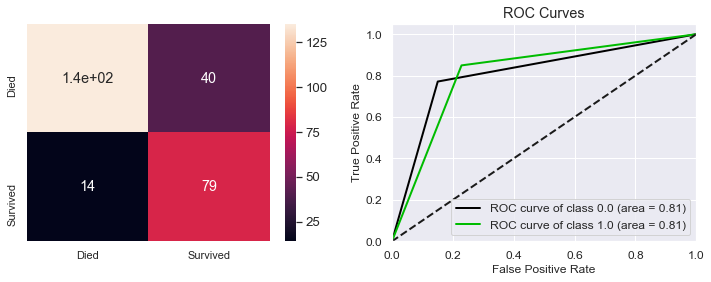

                 Died   Survived  accuracy   macro avg  weighted avg
f1-score     0.833333   0.745283  0.798507    0.789308      0.802779
precision    0.906040   0.663866  0.798507    0.784953      0.822002
recall       0.771429   0.849462  0.798507    0.810445      0.798507
support    175.000000  93.000000  0.798507  268.000000    268.000000
----------------------------------------------------------------------------------------------------
pca16:


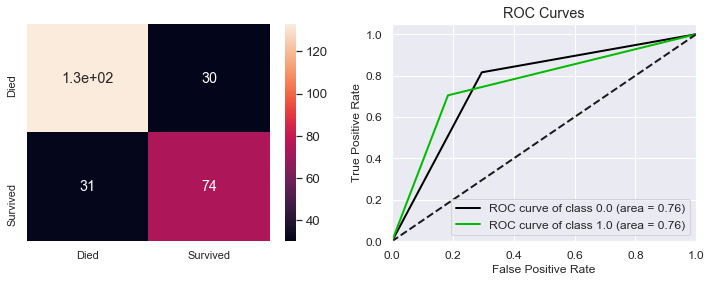

                 Died    Survived  accuracy   macro avg  weighted avg
f1-score     0.813456    0.708134  0.772388    0.760795      0.772192
precision    0.810976    0.711538  0.772388    0.761257      0.772017
recall       0.815951    0.704762  0.772388    0.760356      0.772388
support    163.000000  105.000000  0.772388  268.000000    268.000000
----------------------------------------------------------------------------------------------------
pca10:


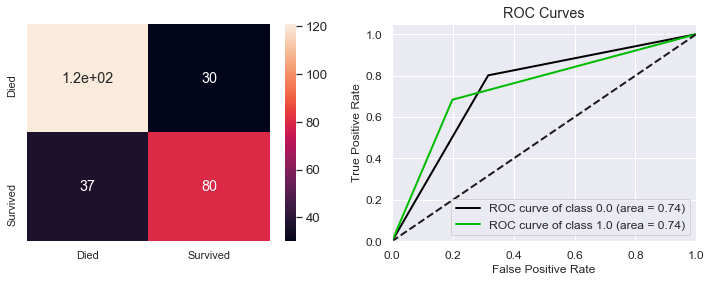

                 Died    Survived  accuracy   macro avg  weighted avg
f1-score     0.783172    0.704846      0.75    0.744009      0.748977
precision    0.765823    0.727273      0.75    0.746548      0.748993
recall       0.801325    0.683761      0.75    0.742543      0.750000
support    151.000000  117.000000      0.75  268.000000    268.000000
CPU times: user 3.22 s, sys: 440 ms, total: 3.66 s
Wall time: 2.81 s


In [34]:
%%time

parameters = {"n_estimators":np.arange(10,100, 5),"criterion":["gini", "entropy"]}

gnb = GaussianNB()

#full
print("full:")
gnb.fit(X_train_full, y_train_full)
preditor_full = gnb.predict(X_test_full)
df_resultado = avalia_resultado(y_test_full, preditor_full)
df_resumo = df_resumo.append({"Modelo":"GaussianNB",
                              "Tabela":"Full",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":{},
                              "Preditor":preditor_full},ignore_index=True,)
print(df_resultado)
print('-'*100)

#less
print("less:")
gnb.fit(X_train_less, y_train_less)
preditor_less = gnb.predict(X_test_less)
df_resultado = avalia_resultado(y_test_less, preditor_less)
df_resumo = df_resumo.append({"Modelo":"GaussianNB",
                              "Tabela":"Less",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":{},
                              "Preditor":preditor_less},ignore_index=True,)
print(df_resultado)
print('-'*100)

#pca16
print("pca16:")
gnb.fit(X_train_pca16, y_train_pca16)
preditor_pca16 = gnb.predict(X_test_pca16)
df_resultado = avalia_resultado(y_test_pca16, preditor_pca16)
df_resumo = df_resumo.append({"Modelo":"GaussianNB",
                              "Tabela":"pca16",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":{},
                              "Preditor":preditor_pca16},ignore_index=True,)
print(df_resultado)
print('-'*100)

#pca10
print("pca10:")
gnb.fit(X_train_pca10, y_train_pca10)
preditor_pca10 = gnb.predict(X_test_pca10)
df_resultado = avalia_resultado(y_test_pca10, preditor_pca10)
df_resumo = df_resumo.append({"Modelo":"GaussianNB",
                              "Tabela":"pca10",
                              "Accuracy":df_resultado.at["f1-score","accuracy"],
                              "F-measure":df_resultado.at["f1-score","Survived"],
                              "best_params":{},
                              "Preditor":preditor_pca10},ignore_index=True,)
print(df_resultado)

***
# Resumo

In [35]:
#Utiliza a estrutura previamente criada para printar os resultados de forma resumida
df_resumo[["Modelo","Tabela","Accuracy","F-measure","best_params"]]

,Modelo,Tabela,Accuracy,F-measure,best_params
0,KNN,Full,0.708955,0.576087,{'n_neighbors': 8}
1,KNN,Less,0.753731,0.582278,{'n_neighbors': 4}
2,KNN,pca16,0.701493,0.540230,{'n_neighbors': 6}
3,KNN,pca10,0.641791,0.524752,{'n_neighbors': 6}
4,Decision Tree,Full,0.791045,0.752212,"{'criterion': 'entropy', 'max_depth': 3, 'spli..."
5,Decision Tree,Less,0.832090,0.748603,"{'criterion': 'entropy', 'max_depth': 5, 'spli..."
6,Decision Tree,pca16,0.787313,0.713568,"{'criterion': 'gini', 'max_depth': 7, 'splitte..."
7,Decision Tree,pca10,0.768657,0.712963,"{'criterion': 'entropy', 'max_depth': 7, 'spli..."
8,Random Forest,Full,0.779851,0.712195,"{'criterion': 'entropy', 'n_estimators': 10}"
9,Random Forest,Less,0.791045,0.711340,"{'criterion': 'gini', 'n_estimators': 65}"


Text(0.5, 1, 'F-measure')

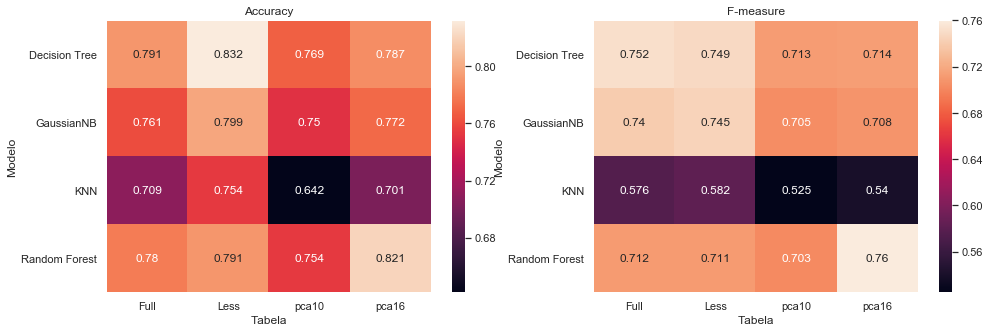

In [36]:
fig, axs = plt.subplots(ncols=2,figsize=(16,5))

#Accuracy
mat = df_resumo.pivot(index='Modelo', columns='Tabela', values='Accuracy')
sns.heatmap(mat,annot=True,fmt='.3g',ax=axs[0])
axs[0].set_title('Accuracy')

#Accuracy
mat = df_resumo.pivot(index='Modelo', columns='Tabela', values='F-measure')
sns.heatmap(mat,annot=True,fmt='.3g',ax=axs[1])
axs[1].set_title('F-measure')

### Curva ROC:

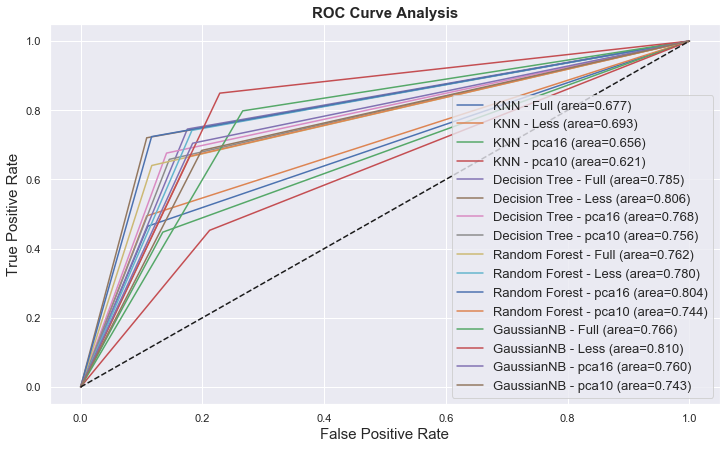

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
fig = plt.figure(figsize=(12,7))

y_test_dict = {'Full':y_test_full,'Less':y_test_less,'pca16':y_test_pca16,'pca10':y_test_pca10}

#Plot de cada curva
for index, row in df_resumo.iterrows():
    fpr, tpr, _ = roc_curve(y_test_dict[row.Tabela], row.Preditor)
    area        = roc_auc_score(y_test_dict[row.Tabela], row.Preditor)
    label       = "%s - %s (area=%.3f)"%(row.Modelo,row.Tabela,area)
    
    plt.plot(fpr, tpr,label=label)
    
#Linha base
plt.plot([0,1], [0,1], color='k', linestyle='--')

#legendas
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13})

plt.show()

### Conclusão:
 - percebemos que a base __less__ apresenta um melhor resultado em relação a base __pca16__ para 3 dos 4 modelos, considerando que ambas tem o mesmo número de colunas.
 - pela a nossa avaliação os melhores modelos são: __Decision Tree__ utilizando a base __less__ e __Random Forest__ utilizando a base __pca16__.
 - menção honrosa ao modelo __Decision Tree__ utilizando a base __Full__, com o parâmetro max_depth = 3 já apresenta bons resultados. Portanto, consiste em um modelo mais parcimonioso. 
